# [Spotahome.com](https://www.spotahome.com/s/london--uk/for-rent:apartments/for-rent:studios/bedrooms:1/bedrooms:2/bedrooms:3/bedrooms:3more?areaId[]=219&areaId[]=231&areaId[]=232&areaId[]=233&areaId[]=234&areaId[]=235&areaId[]=236&areaId[]=237&areaId[]=241)

## Dataframe with information from search result page

In [1]:
import requests                 # requests on websites
from bs4 import BeautifulSoup   # html parsing

import pandas as pd             # pandas for data frame
import numpy as np              # numpy for numerical operations

import math                     # for math methods
import time                     # for sleep timer
import random                   # for random number generator

import sql_functions as sf      # for sql functions
from sql_functions import *     # functions from file for upload on schema

import sqlalchemy               # for sql connection
import psycopg2                 # for upload on engine

import datetime as dt           # for the csv file with the current date and time
import re                       # for regular expressions

import matplotlib as mpl        # for plotting
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for plotting

In [2]:
# Creating a function to get all the descriptions
def get_description(bs):
    # find all the descriptions and save them to an empty list
    lst_name = []
    descriptions = bs.find_all(
        class_='homecard-content__title__HomecardContent___OmV4c homecard-content__title--rebranding-style__HomecardContent___OmV4c')
    # iterate over the descriptions to get the text and strip the strings and save them in a list
    for description in descriptions:
        lst_name.append(
            description.get_text()
                .strip()
        )
    return lst_name


# Creating a function to get all the housing types
def get_housing(bs):
    # find all the housing types and save them to an empty list
    lst_name = []
    housings = bs.find_all(
        class_='homecard-content__type__HomecardContent___OmV4c homecard-content__type--rebranding-style__HomecardContent___OmV4c')
    # iterate over the housing types to get the text and strip the strings and save them in a list
    for housing in housings:
        lst_name.append(
            housing.get_text()
                .strip()
        )
    return lst_name


# Creating a function to get all the available dates
def get_available(bs):
    # find all the available dates and save them to an empty list
    lst_name = []
    availables = bs.find_all(
        class_='homecard-content__available-from__HomecardContent___OmV4c homecard-content__available-from--rebranding-style__HomecardContent___OmV4c')
    # iterate over the available appartements to get the text and strip the string and save them in a list
    for available in availables:
        lst_name.append(
            available.get_text()
                .strip()
                .replace('From ', '')
        )
    return lst_name


# Creating a function to get all the prices
def get_price(bs):
    # find all the prices and save them to an empty list
    lst_name = []
    prices = bs.find_all(class_='price__Price___OmV4c')
    # iterate over the prices to get the text and strip the strings and save them in a list
    for price in prices:
        lst_name.append(
            price.get_text()
                .strip()
                .replace('£', '')
                
        )
    return lst_name


# Creating a function to get all the prices per period
def get_prices_period(bs):
    # find all the aprices per period and save them to an empty list
    lst_name = []
    prices_period = bs.find_all(
        class_='price-monthly__Price___OmV4c price-monthly--rebranding-style__Price___OmV4c')
    # iterate over the prices per period to get the text and strip the string and save them in a list
    for price_period in prices_period:
        lst_name.append(
            price_period.get_text()
                .strip()
                .replace('/', '')
        )
    return lst_name


# Creating a function to get all the ID's
def get_ids(bs):
    # find all the prices and save them to an empty list
    lst_name = []
    ids = bs.find_all(class_='l-list__item')
    # iterate over the prices to get the text and strip the strings and save them in a list
    for id in ids:
        lst_name.append(
            id.get('data-homecard-scroll')
                .strip()
        )
    return lst_name


# Create dictionary in which every location ID gets assigned a location name
location_dict = {219: 'Lambeth',
                 231: 'Hammersmith and Fulham',
                 232: 'Kensington and Chelsea',
                 233: 'City of Westminster',
                 234: 'Camden',
                 235: 'Tower Hamlets',
                 236: 'Islington',
                 237: 'Hackney',
                 241: 'City of London'
                 }


# Creating a function to get the search result from all pages
# the website spotahome shows 60 search results per page. To iterate trough all the pages, we get the information how many search results are there, then divide it by 60 and round it up to get the number of pages.
def page_results(property_type, location):
    # get the url from the website with the property type and the location as a variable to iterate trough it
    page = requests.get(
        f'https://www.spotahome.com/s/london--uk/for-rent:{property_type}?areaId[]={location}')
    html = page.content
    bs = BeautifulSoup(html, 'html.parser')

    # Extracting the total number of search results
    results = bs.find_all('h1', {'class': 'search-title__title'})

    # define the variable result_text in case the first search gives us no results
    result_text = 0

    # iterate over the results to get the text and strip the string
    for result in results:
        result_text = result.find("strong").get_text().strip()

    # convert the extracted string to an integer to perform mathematical operations
    result_converted = int(result_text)

    # divide the converted result by 60 since one pages shows 60 results and round it up to get the number of pages
    page_site = result_converted / 60
    page_site = math.ceil(page_site)

    # convert the number of pages from a float to an integer to iterate trough the pages
    page_converted = int(page_site)

    # create an empty data frame to store the results from every loop cycle
    df_search = pd.DataFrame()

    # split the url to get access to the part where the page is definde
    begin = f'https://www.spotahome.com/s/london--uk/for-rent:{property_type}'
    end = f'?areaId[]={location}'

    # range is including in the beginning and excluding in the end so we add plus 1 to iterate through all calculated pages
    page_converted = page_converted + 1

    # for loop to get the page numbers
    for page_number in range(page_converted):
        # sleep timer to reduce the traffic for the server
        time.sleep(random.randint(2,6)/10)

        # get the url from the website with the property type, the location and the page number as a variable to iterate trough it
        # middle =
        page = requests.get(begin+f'/page:{page_number}'+end)
        html = page.content
        bs = BeautifulSoup(html, 'html.parser')

        # Create a dictionary to store the results from every loop cycle.
        # The keys are the column names and the values are the functions we created before.
        # The functions are called with the beautiful soup object as a parameter.
        spotahome_dict = {
            'platform_id': get_ids(bs),
            'platform': 'Spotahome',
            'neighborhood': location_dict[location],
            'property_type': property_type,
            'housing_type': get_housing(bs),
            'price_pcm': get_price(bs),
            'title': get_description(bs),
            'furnished': 'furnished',
            'available_from': get_available(bs),
            'let_type': '',
            'available_today': '',
            'scraping_date': dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        }
        # the ditionary is stored in a dataframe
        df_page = pd.DataFrame(data=spotahome_dict)

        # the temporary data frame gets appended to the data frame we created earlier outside the for loop
        # for every iteration, the data frame page stores the results in the data frame search
        #df_search = df_search.append(df_page)
        df_search = pd.concat([df_search, df_page], axis=0, ignore_index=True)
    # the data frame search gets returned to the for loop to access it outside the function
    return (df_search)


# creating a list with different property types given from the website
property_types = ['studios', 'apartments/bedrooms:1',
                  'apartments/bedrooms:2', 'apartments/bedrooms:3', 'apartments/bedrooms:3more']
# creating a list with the different location IDs given from the website
locations = [219, 231, 232, 233, 234, 235, 236, 237, 241]

# creating an empty data frame
df_complete = pd.DataFrame()
# for loop to get the different property types
for property_type in property_types:
    # for loop to get the different locations
    for location in locations:
        # append the result from data frame search by calling the function page_results with the property type and the location as a parameter to data frame complete
        df_complete = pd.concat([df_complete, page_results(
            property_type, location)], axis=0, ignore_index=True)

df_complete = df_complete.join(df_complete['price_pcm'].str.split(
    '-', expand=True).add_prefix('price_pcm_'))
df_complete = df_complete.join(df_complete['available_from'].str.split(
    ' ', expand=True).add_prefix('available_from_'))


In [3]:
# def get_description(bs):
#     lst_name = []
#     descriptions = bs.find_all(
#         class_='homecard-content__title__HomecardContent___OmV4c homecard-content__title--rebranding-style__HomecardContent___OmV4c')
#     for description in descriptions:
#         lst_name.append(
#             description.get_text()
#                 .strip()
#         )
#     return lst_name


# def get_housing(bs):
#     lst_name = []
#     housings = bs.find_all(
#         class_='homecard-content__type__HomecardContent___OmV4c homecard-content__type--rebranding-style__HomecardContent___OmV4c')
#     for housing in housings:
#         lst_name.append(
#             housing.get_text()
#                 .strip()
#         )
#     return lst_name


# def get_available(bs):
#     lst_name = []
#     availables = bs.find_all(
#         class_='homecard-content__available-from__HomecardContent___OmV4c homecard-content__available-from--rebranding-style__HomecardContent___OmV4c')
#     for available in availables:
#         lst_name.append(
#             available.get_text()
#                 .strip()
#                 .replace('From ', '')
#         )
#     return lst_name


# def get_price(bs):
#     lst_name = []
#     prices = bs.find_all(class_='price__Price___OmV4c')
#     for price in prices:
#         lst_name.append(
#             price.get_text()
#                 .strip()
#                 .replace('£', '')
#         )
#     return lst_name


# def get_prices_period(bs):
#     lst_name = []
#     prices_period = bs.find_all(
#         class_='price-monthly__Price___OmV4c price-monthly--rebranding-style__Price___OmV4c')
#     for price_period in prices_period:
#         lst_name.append(
#             price_period.get_text()
#                 .strip()
#                 .replace('/', '')
#         )
#     return lst_name


# def get_ids(bs):
#     lst_name = []
#     ids = bs.find_all(class_='l-list__item')
#     for id in ids:
#         lst_name.append(
#             id.get('data-homecard-scroll')
#                 .strip()
#         )
#     return lst_name


# # Create dictionary in which every location ID gets assigned a location name
# location_dict = {219: 'Lambeth',
#                  231: 'Hammersmith and Fulham',
#                  232: 'Kensington and Chelsea',
#                  233: 'City of Westminster',
#                  234: 'Camden',
#                  235: 'Tower Hamlets',
#                  236: 'Islington',
#                  237: 'Hackney',
#                  241: 'City of London'
#                  }


# # the website spotahome shows 60 search results per page. To iterate trough all the pages, we get the information how many search results are there, then divide it by 60 and round it up to get the number of pages.
# def page_results(property_type, location):
#     page = requests.get(
#         f'https://www.spotahome.com/s/london--uk/for-rent:{property_type}?areaId[]={location}')
#     html = page.content
#     bs = BeautifulSoup(html, 'html.parser')

#     # Extracting the total number of search results
#     results = bs.find_all('h1', {'class': 'search-title__title'})

#     result_text = 0

#     for result in results:
#         result_text = result.find("strong").get_text().strip()

#     # convert the extracted string to an integer to perform mathematical operations
#     result_converted = int(result_text)

#     # divide the converted result by 60 since one pages shows 60 results and round it up to get the number of pages
#     page_site = result_converted / 60
#     page_site = math.ceil(page_site)

#     # convert the number of pages from a float to an integer to iterate through the pages
#     page_converted = int(page_site)

#     df_search = pd.DataFrame()

#     begin = f'https://www.spotahome.com/s/london--uk/for-rent:{property_type}'
#     end = f'?areaId[]={location}'

#     # range is including in the beginning and excluding in the end so we add plus 1 to iterate through all calculated pages
#     page_converted = page_converted + 1

#     for page_number in range(page_converted):
#         time.sleep(random.randint(2, 6)/10)
#         page = requests.get(begin+f'/page:{page_number}'+end)
#         html = page.content
#         bs = BeautifulSoup(html, 'html.parser')

#         # Create a dictionary to store the results from every loop cycle.
#         # The keys are the column names and the values are the functions we created before.
#         # The functions are called with the beautiful soup object as a parameter.

#         spotahome_dict = {
#             'platform_id': get_ids(bs),
#             'platform': 'Spotahome',
#             'neighborhood': location_dict[location],
#             'housing_type': property_type,
#             'property_type': get_housing(bs),
#             'price_pcm': get_price(bs),
#             'title': get_description(bs),
#             'furnished': 'furnished',
#             'available_from': get_available(bs),
#             'let_type': '',
#             'available_today': '',
#             'scraping_date': dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
#         }
#         df_page = pd.DataFrame(data=spotahome_dict)

#         # the temporary data frame stores the data to the data frame we created earlier outside the for loop
#         # for every iteration, the data frame page stores the results in the data frame search
#         df_search = pd.concat([df_search, df_page], axis=0, ignore_index=True)
#     return (df_search)


# property_types = ['studios', 'apartments/bedrooms:1',
#                   'apartments/bedrooms:2', 'apartments/bedrooms:3', 'apartments/bedrooms:3more']
# locations = [219, 231, 232, 233, 234, 235, 236, 237, 241]

# df_complete = pd.DataFrame()
# for property_type in property_types:
#     for location in locations:
#         df_complete = pd.concat([df_complete, page_results(
#             property_type, location)], axis=0, ignore_index=True)

# # split the date in seperate columns for further analysis
# df_complete = df_complete.join(df_complete['price_pcm'].str.split(
#     '-', expand=True).add_prefix('price_pcm_'))
# df_complete = df_complete.join(df_complete['available_from'].str.split(
#     ' ', expand=True).add_prefix('available_from_'))

In [4]:
df_complete.head(10)

,platform_id,platform,neighborhood,property_type,housing_type,price_pcm,title,furnished,available_from,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,available_from_0,available_from_1,available_from_2
0,654298,Spotahome,Hammersmith and Fulham,studios,Studio,2650,The Armadale Road Residence II,furnished,16 December,,,2022-10-05 21:34:22,2650,None,16,December,None
1,654299,Spotahome,Hammersmith and Fulham,studios,Studio,2500,The Armadale Road Residence III,furnished,20 December,,,2022-10-05 21:34:22,2500,None,20,December,None
2,113567,Spotahome,Hammersmith and Fulham,studios,Studio,1400,Studio flat with double bed to rent in Kensing...,furnished,18 June 2023,,,2022-10-05 21:34:22,1400,None,18,June,2023
3,761515,Spotahome,Kensington and Chelsea,studios,Studio,2250,Studio for rent in a co-living building in Not...,furnished,10 October,,,2022-10-05 21:34:25,2250,None,10,October,None
4,607194,Spotahome,Kensington and Chelsea,studios,Studio,3033,"Studio for rent in Earls Court, London",furnished,12 October,,,2022-10-05 21:34:25,3033,None,12,October,None
5,759191,Spotahome,Kensington and Chelsea,studios,Studio,2300,Studio for rent in a co-living building in Not...,furnished,10 October,,,2022-10-05 21:34:25,2300,None,10,October,None
6,759607,Spotahome,Kensington and Chelsea,studios,Studio,2300,Studio for rent in a co-living building in Not...,furnished,10 October,,,2022-10-05 21:34:25,2300,None,10,October,None
7,605392,Spotahome,Kensington and Chelsea,studios,Studio,2438,Studio Apartment for rent in Kensington and Ch...,furnished,10 November,,,2022-10-05 21:34:25,2438,None,10,November,None
8,838188,Spotahome,Kensington and Chelsea,studios,Studio,3000,"Studio for rent in South Kensington, London",furnished,5 November,,,2022-10-05 21:34:25,3000,None,5,November,None
9,695376,Spotahome,Kensington and Chelsea,studios,Studio,1300,Studio apartment for rent in Kensington And Ch...,furnished,19 December,,,2022-10-05 21:34:25,1300,None,19,December,None


In [5]:
df_complete


,platform_id,platform,neighborhood,property_type,housing_type,price_pcm,title,furnished,available_from,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,available_from_0,available_from_1,available_from_2
0,654298,Spotahome,Hammersmith and Fulham,studios,Studio,2650,The Armadale Road Residence II,furnished,16 December,,,2022-10-05 21:34:22,2650,None,16,December,None
1,654299,Spotahome,Hammersmith and Fulham,studios,Studio,2500,The Armadale Road Residence III,furnished,20 December,,,2022-10-05 21:34:22,2500,None,20,December,None
2,113567,Spotahome,Hammersmith and Fulham,studios,Studio,1400,Studio flat with double bed to rent in Kensing...,furnished,18 June 2023,,,2022-10-05 21:34:22,1400,None,18,June,2023
3,761515,Spotahome,Kensington and Chelsea,studios,Studio,2250,Studio for rent in a co-living building in Not...,furnished,10 October,,,2022-10-05 21:34:25,2250,None,10,October,None
4,607194,Spotahome,Kensington and Chelsea,studios,Studio,3033,"Studio for rent in Earls Court, London",furnished,12 October,,,2022-10-05 21:34:25,3033,None,12,October,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,844665,Spotahome,Hackney,apartments/bedrooms:3more,Apartment,8250-10950,4-bedroom apartment for rent in London,furnished,8 January 2023,,,2022-10-05 21:36:12,8250,10950,8,January,2023
831,843245,Spotahome,Hackney,apartments/bedrooms:3more,Apartment,9000-11250,4-bedroom apartment for rent in London,furnished,11 January 2023,,,2022-10-05 21:36:12,9000,11250,11,January,2023
832,398966,Spotahome,Hackney,apartments/bedrooms:3more,Apartment,2100,4-bedroom apartment in Hackney,furnished,6 January 2024,,,2022-10-05 21:36:12,2100,None,6,January,2024
833,602243,Spotahome,Hackney,apartments/bedrooms:3more,Apartment,9000-11250,4 bedrooms warehouse conversion for rent in Ha...,furnished,4 August 2023,,,2022-10-05 21:36:12,9000,11250,4,August,2023


In [6]:
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   platform_id       835 non-null    object
 1   platform          835 non-null    object
 2   neighborhood      835 non-null    object
 3   property_type     835 non-null    object
 4   housing_type      835 non-null    object
 5   price_pcm         835 non-null    object
 6   title             835 non-null    object
 7   furnished         835 non-null    object
 8   available_from    835 non-null    object
 9   let_type          835 non-null    object
 10  available_today   835 non-null    object
 11  scraping_date     835 non-null    object
 12  price_pcm_0       835 non-null    object
 13  price_pcm_1       246 non-null    object
 14  available_from_0  835 non-null    object
 15  available_from_1  835 non-null    object
 16  available_from_2  435 non-null    object
dtypes: object(17)
me

## Dataframe with information from every detail page for every apartment advert

In [7]:
df_details_complete = pd.DataFrame()

for idx, row in df_complete.iterrows():
    time.sleep(random.randint(2,6)/10)
    page = f"https://www.spotahome.com/london/for-rent:{row['housing_type'].lower() + 's'}/{row['platform_id']}"
    website = requests.get(page)
    results = BeautifulSoup(website.content, 'html.parser')

    details = results.find(
        'div', class_='property-title__details').find_all('span')

    details_lst = (detail.get_text() for detail in details)
    details_lst = [detail.strip() for detail in details_lst]

    details_lst.pop(0)

    details_lst = [i.split(' ', 1) for i in details_lst]

    row_dict = {}

    for value_key_tuple in details_lst:
        new_key_value = {'id': row['platform_id']}
        row_dict.update(new_key_value)
        key = value_key_tuple[1]
        value = value_key_tuple[0]
        row_dict[key] = value

    df_details = pd.DataFrame(data=row_dict, index=[0])
    df_details_complete = pd.concat([df_details_complete, df_details])

In [8]:
# df_details_complete = pd.DataFrame()

# #with iterrows we can grab the id's from the previous code, iterate trough all of them and get the details for every id
# for idx, row in df_complete.iterrows():
#     time.sleep(random.randint(2,6)/10)
#     page = f"https://www.spotahome.com/london/for-rent:{row['housing_type'].lower() + 's'}/{row['platform_id']}"
#     website = requests.get(page)
#     results = BeautifulSoup(website.content, 'html.parser')

#     details = results.find(
#         'div', class_='property-title__details').find_all('span')

#     #our information is first stored in a list
#     details_lst = (detail.get_text() for detail in details)
#     details_lst = [detail.strip() for detail in details_lst]

#     #since we don't need the property_type again, we drop that information
#     details_lst.pop(0)

#     #we can split our information on the space and get three lists inside a list
#     details_lst = [i.split(' ', 1) for i in details_lst]

#     row_dict = {}

#     #the three lists are now get stored in a dictionary (with the id's)
#     for value_key_tuple in details_lst:
#         new_key_value = {'id': row['platform_id']}
#         row_dict.update(new_key_value)
#         key = value_key_tuple[1]
#         value = value_key_tuple[0]
#         row_dict[key] = value

#     #the dictionary is then converted to a data frame
#     df_details = pd.DataFrame(data=row_dict, index=[0])
#     df_details_complete = pd.concat([df_details_complete, df_details])


In [9]:
df_details_complete

,id,bathrooms,m2,bedrooms
0,654298,1,NaN,NaN
0,654299,1,NaN,NaN
0,113567,1,NaN,NaN
0,761515,1,NaN,NaN
0,NaN,NaN,NaN,NaN
...,...,...,...,...
0,844665,2,NaN,4
0,843245,2,NaN,4
0,398966,2,85,5
0,602243,2,NaN,4


In [10]:
df_details_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 0 to 0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         711 non-null    object
 1   bathrooms  528 non-null    object
 2   m2         272 non-null    object
 3   bedrooms   595 non-null    object
dtypes: object(4)
memory usage: 32.6+ KB


## Import df_complete to DBeaver

In [11]:
# call the schema created for this project
schema = 'capstone_jmrs'
# get the function to connect to the database
engine = get_engine()

# give the table a unique name
table_name = "spotahome_df_complete"

# import the table to sql
if engine != None:
    try:
        df_complete.to_sql(name=table_name,
                           con=engine,
                           if_exists='replace',
                           schema=schema,
                           index=False,
                           chunksize=5000,
                           method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The spotahome_df_complete table was imported successfully.


## Import df_details_complete to DBeaver

In [12]:
# call the schema created for this project
schema = 'capstone_jmrs'
# get the function to connect to the database
engine = get_engine()

# give the table a unique name
table_name = "spotahome_df_details_complete"

# import the table to sql
if engine != None:
    try:
        df_details_complete.to_sql(name=table_name,
                                   con=engine,
                                   if_exists='replace',
                                   schema=schema,
                                   index=False,
                                   chunksize=5000,
                                   method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None


The spotahome_df_details_complete table was imported successfully.


## Create a .csv file for both data frames

In [184]:
# create a .csv file with the current date and time
today = dt.datetime.today().strftime('%Y-%m-%d-%H-%M')
df_complete.to_csv('data/spotahome_df_complete_{}.csv'.format(today), sep='\t')
print("The csv-file was created successfully.")


today = dt.datetime.today().strftime('%Y-%m-%d-%H-%M')
df_details_complete.to_csv('data/spotahome_df_details_complete{}.csv'.format(today), sep='\t')
print("The csv-file was created successfully.")

## Clean the data with SQL

In [185]:
engine = get_engine()
schema = 'capstone_jmrs'

### drop existing tables because they can't be overwritten

In [186]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.spotahome_merged;
"""
result = engine.execute(sql_text)

In [187]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.spotahome_eda;
"""
result = engine.execute(sql_text)

In [188]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.spotahome_clean;
"""
result = engine.execute(sql_text)

### join the two tables with the raw data

In [189]:
sql_text = f"""
CREATE TABLE capstone_jmrs.spotahome_merged AS
SELECT *
FROM capstone_jmrs.spotahome_df_complete sdcaf
LEFT JOIN capstone_jmrs.spotahome_df_details_complete sddc  
	   ON sdcaf.platform_id = sddc.id;
"""
result = engine.execute(sql_text)

### properties who are available this year (2022) don't have the year in it, so we fill it in

In [190]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
	SET available_from_2 = COALESCE(available_from_2, '2022');
"""
result = engine.execute(sql_text)

### the date for availability, which was splitted, is merged back into one column

In [191]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	ADD available_from_total VARCHAR;"""
result = engine.execute(sql_text)

In [192]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged 
	SET available_from_total = available_from_0 || '-' || available_from_1 || '-' || available_from_2;
"""
result = engine.execute(sql_text)

### change the column types - dates to DATE, numbers to INT or FLOAT and text to VARCHAR

In [193]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
    ALTER COLUMN platform_id TYPE VARCHAR,
    ALTER COLUMN platform TYPE VARCHAR,
    ALTER COLUMN neighborhood TYPE VARCHAR,
    ALTER COLUMN housing_type TYPE VARCHAR,
    ALTER COLUMN property_type TYPE VARCHAR,
    ALTER COLUMN title TYPE VARCHAR,
    ALTER COLUMN furnished TYPE VARCHAR,
    ALTER COLUMN let_type TYPE VARCHAR,
    --available_today
    ALTER COLUMN scraping_date TYPE DATE USING scraping_date::DATE,
    ALTER COLUMN price_pcm_0 TYPE FLOAT USING price_pcm_0::FLOAT,
    ALTER COLUMN price_pcm_1 TYPE FLOAT USING price_pcm_1::FLOAT,
    ALTER COLUMN bathrooms TYPE FLOAT USING bathrooms::FLOAT,
    ALTER COLUMN m2 TYPE FLOAT USING m2::FLOAT,
    ALTER COLUMN bedrooms TYPE FLOAT USING bedrooms::FLOAT,
    ALTER COLUMN available_from_total TYPE DATE USING available_from_total::DATE;
"""
result = engine.execute(sql_text)

### drop columns that are no longer needed

In [194]:
sql_text = f"""   
ALTER TABLE capstone_jmrs.spotahome_merged
  DROP COLUMN available_from,
  DROP COLUMN available_from_0,
  DROP COLUMN available_from_1,
  DROP COLUMN available_from_2,
  DROP COLUMN id;
  """
result = engine.execute(sql_text)

### square meters who are not logical are replaced with null values (properties with 1m<sup>2</sup> or 1000m<sup>2</sup> are not realistic)

In [195]:
sql_text = f""" 
UPDATE capstone_jmrs.spotahome_merged
SET m2 = NULL
WHERE m2 = '1'
	OR m2 = '3'
	OR m2 = '8'
	OR m2 = '1000';
"""
result = engine.execute(sql_text)

### rename columns

In [196]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN available_from_total TO available_from;
"""
result = engine.execute(sql_text)

In [197]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN furnished TO furniture;
"""
result = engine.execute(sql_text)

In [198]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN m2 TO size_sqm;
"""
result = engine.execute(sql_text)

In [199]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN neighborhood TO neighbourhood;
"""
result = engine.execute(sql_text)

### fill missing number of bedrooms with information from property type

In [200]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '0')
WHERE property_type = 'studios';
"""
result = engine.execute(sql_text)

In [201]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '1')
WHERE property_type = 'apartments/bedrooms:1';
"""
result = engine.execute(sql_text)

In [202]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '2')
WHERE property_type = 'apartments/bedrooms:2';
"""
result = engine.execute(sql_text)

In [203]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '3')
WHERE property_type = 'apartments/bedrooms:3';
"""
result = engine.execute(sql_text)

In [204]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '4')
WHERE property_type = 'apartments/bedrooms:3more';
"""
result = engine.execute(sql_text)

### drop columns that are no longer needed

In [205]:
sql_text = f"""   
ALTER TABLE capstone_jmrs.spotahome_merged
  DROP COLUMN property_type,
	DROP COLUMN title;
"""
result = engine.execute(sql_text)

### rename columns

In [206]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN housing_type TO property_type;
"""
result = engine.execute(sql_text)

### if a property is available {today} set it as 'available', if not, set it as 'occupied'

In [207]:
sql_text = f"""
 UPDATE capstone_jmrs.spotahome_merged
	SET available_today = CASE 
      						WHEN available_from = '2022-10-05'  THEN 'available'
      						ELSE 'occupied'
						  END;
"""
result = engine.execute(sql_text)

### fill the empty column let_type with null values

In [208]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET let_type = NULL 
WHERE let_type = '';
"""
result = engine.execute(sql_text)

## Get the table back to python for the EDA

In [209]:
spotahome_eda = sf.get_dataframe(f'SELECT * FROM capstone_jmrs.spotahome_merged')
spotahome_eda

,platform_id,platform,neighbourhood,property_type,price_pcm,furniture,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms,available_from
0,760899,Spotahome,Kensington and Chelsea,Apartment,2650,furnished,None,occupied,2022-10-05,2650.0,NaN,1.0,80.0,1.0,2022-11-01
1,654350,Spotahome,Tower Hamlets,Apartment,3215,furnished,None,occupied,2022-10-05,3215.0,NaN,1.0,NaN,1.0,2022-10-15
2,605379,Spotahome,Kensington and Chelsea,Studio,2684,furnished,None,occupied,2022-10-05,2684.0,NaN,NaN,NaN,0.0,2022-12-05
3,728336,Spotahome,Camden,Studio,1280,furnished,None,occupied,2022-10-05,1280.0,NaN,1.0,NaN,0.0,2023-11-01
4,619142,Spotahome,Lambeth,Apartment,4500,furnished,None,available,2022-10-05,4500.0,NaN,1.0,NaN,1.0,2022-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,844665,Spotahome,Hackney,Apartment,8250-10950,furnished,None,occupied,2022-10-05,8250.0,10950.0,2.0,NaN,4.0,2023-01-08
831,843245,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-01-11
832,398966,Spotahome,Hackney,Apartment,2100,furnished,None,occupied,2022-10-05,2100.0,NaN,2.0,85.0,5.0,2024-01-06
833,602243,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-08-04


In [210]:
spotahome_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835 entries, 0 to 834
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   platform_id      835 non-null    object 
 1   platform         835 non-null    object 
 2   neighbourhood    835 non-null    object 
 3   property_type    835 non-null    object 
 4   price_pcm        835 non-null    object 
 5   furniture        835 non-null    object 
 6   let_type         0 non-null      object 
 7   available_today  835 non-null    object 
 8   scraping_date    835 non-null    object 
 9   price_pcm_0      835 non-null    float64
 10  price_pcm_1      246 non-null    float64
 11  bathrooms        528 non-null    float64
 12  size_sqm         267 non-null    float64
 13  bedrooms         835 non-null    float64
 14  available_from   835 non-null    object 
dtypes: float64(5), object(10)
memory usage: 98.0+ KB


In [211]:
spotahome_eda.describe()

,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms
count,835.000000,246.000000,528.000000,267.000000,835.000000
mean,4403.203593,7967.321138,1.325758,60.284644,1.262275
std,1938.423474,3810.813926,0.643121,34.902139,1.104580
min,1112.000000,2881.000000,1.000000,12.000000,0.000000
25%,3090.000000,5500.000000,1.000000,40.500000,0.000000
50%,4125.000000,7141.000000,1.000000,55.000000,1.000000
75%,5237.500000,9000.000000,2.000000,75.000000,2.000000
max,13614.000000,27372.000000,5.000000,350.000000,6.000000


In [212]:
spotahome_eda.corr()

,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms
price_pcm_0,1.000000,0.778204,0.486750,0.407698,0.525292
price_pcm_1,0.778204,1.000000,0.642477,0.689806,0.719913
bathrooms,0.486750,0.642477,1.000000,0.732147,0.621643
size_sqm,0.407698,0.689806,0.732147,1.000000,0.801227
bedrooms,0.525292,0.719913,0.621643,0.801227,1.000000


In [213]:
spotahome_eda.duplicated().sum()

0

In [214]:
spotahome_eda.isnull().sum()

platform_id          0
platform             0
neighbourhood        0
property_type        0
price_pcm            0
furniture            0
let_type           835
available_today      0
scraping_date        0
price_pcm_0          0
price_pcm_1        589
bathrooms          307
size_sqm           568
bedrooms             0
available_from       0
dtype: int64

In [215]:
spotahome_eda.dtypes

platform_id         object
platform            object
neighbourhood       object
property_type       object
price_pcm           object
furniture           object
let_type            object
available_today     object
scraping_date       object
price_pcm_0        float64
price_pcm_1        float64
bathrooms          float64
size_sqm           float64
bedrooms           float64
available_from      object
dtype: object

## Calculate new columns

In [216]:
spotahome_eda['avg_price_sqm'] = spotahome_eda[['price_pcm_0', 'price_pcm_1']].mean(axis=1, skipna=True)
spotahome_eda

,platform_id,platform,neighbourhood,property_type,price_pcm,furniture,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms,available_from,avg_price_sqm
0,760899,Spotahome,Kensington and Chelsea,Apartment,2650,furnished,None,occupied,2022-10-05,2650.0,NaN,1.0,80.0,1.0,2022-11-01,2650.0
1,654350,Spotahome,Tower Hamlets,Apartment,3215,furnished,None,occupied,2022-10-05,3215.0,NaN,1.0,NaN,1.0,2022-10-15,3215.0
2,605379,Spotahome,Kensington and Chelsea,Studio,2684,furnished,None,occupied,2022-10-05,2684.0,NaN,NaN,NaN,0.0,2022-12-05,2684.0
3,728336,Spotahome,Camden,Studio,1280,furnished,None,occupied,2022-10-05,1280.0,NaN,1.0,NaN,0.0,2023-11-01,1280.0
4,619142,Spotahome,Lambeth,Apartment,4500,furnished,None,available,2022-10-05,4500.0,NaN,1.0,NaN,1.0,2022-10-05,4500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,844665,Spotahome,Hackney,Apartment,8250-10950,furnished,None,occupied,2022-10-05,8250.0,10950.0,2.0,NaN,4.0,2023-01-08,9600.0
831,843245,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-01-11,10125.0
832,398966,Spotahome,Hackney,Apartment,2100,furnished,None,occupied,2022-10-05,2100.0,NaN,2.0,85.0,5.0,2024-01-06,2100.0
833,602243,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-08-04,10125.0


In [217]:
def my_func(x):
    try:
        return int(x['avg_price_sqm']) / int(x['size_sqm'])
    except (ZeroDivisionError, ValueError):
        return np.nan

spotahome_eda["price_per_sqm"] = spotahome_eda.apply(my_func, axis=1)
spotahome_eda

,platform_id,platform,neighbourhood,property_type,price_pcm,furniture,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms,available_from,avg_price_sqm,price_per_sqm
0,760899,Spotahome,Kensington and Chelsea,Apartment,2650,furnished,None,occupied,2022-10-05,2650.0,NaN,1.0,80.0,1.0,2022-11-01,2650.0,33.125000
1,654350,Spotahome,Tower Hamlets,Apartment,3215,furnished,None,occupied,2022-10-05,3215.0,NaN,1.0,NaN,1.0,2022-10-15,3215.0,NaN
2,605379,Spotahome,Kensington and Chelsea,Studio,2684,furnished,None,occupied,2022-10-05,2684.0,NaN,NaN,NaN,0.0,2022-12-05,2684.0,NaN
3,728336,Spotahome,Camden,Studio,1280,furnished,None,occupied,2022-10-05,1280.0,NaN,1.0,NaN,0.0,2023-11-01,1280.0,NaN
4,619142,Spotahome,Lambeth,Apartment,4500,furnished,None,available,2022-10-05,4500.0,NaN,1.0,NaN,1.0,2022-10-05,4500.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,844665,Spotahome,Hackney,Apartment,8250-10950,furnished,None,occupied,2022-10-05,8250.0,10950.0,2.0,NaN,4.0,2023-01-08,9600.0,NaN
831,843245,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-01-11,10125.0,NaN
832,398966,Spotahome,Hackney,Apartment,2100,furnished,None,occupied,2022-10-05,2100.0,NaN,2.0,85.0,5.0,2024-01-06,2100.0,24.705882
833,602243,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-08-04,10125.0,NaN


In [218]:
spotahome_eda['price_per_sqm'] = spotahome_eda['price_per_sqm'].round(decimals = 2)
spotahome_eda

,platform_id,platform,neighbourhood,property_type,price_pcm,furniture,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms,available_from,avg_price_sqm,price_per_sqm
0,760899,Spotahome,Kensington and Chelsea,Apartment,2650,furnished,None,occupied,2022-10-05,2650.0,NaN,1.0,80.0,1.0,2022-11-01,2650.0,33.12
1,654350,Spotahome,Tower Hamlets,Apartment,3215,furnished,None,occupied,2022-10-05,3215.0,NaN,1.0,NaN,1.0,2022-10-15,3215.0,NaN
2,605379,Spotahome,Kensington and Chelsea,Studio,2684,furnished,None,occupied,2022-10-05,2684.0,NaN,NaN,NaN,0.0,2022-12-05,2684.0,NaN
3,728336,Spotahome,Camden,Studio,1280,furnished,None,occupied,2022-10-05,1280.0,NaN,1.0,NaN,0.0,2023-11-01,1280.0,NaN
4,619142,Spotahome,Lambeth,Apartment,4500,furnished,None,available,2022-10-05,4500.0,NaN,1.0,NaN,1.0,2022-10-05,4500.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,844665,Spotahome,Hackney,Apartment,8250-10950,furnished,None,occupied,2022-10-05,8250.0,10950.0,2.0,NaN,4.0,2023-01-08,9600.0,NaN
831,843245,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-01-11,10125.0,NaN
832,398966,Spotahome,Hackney,Apartment,2100,furnished,None,occupied,2022-10-05,2100.0,NaN,2.0,85.0,5.0,2024-01-06,2100.0,24.71
833,602243,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-08-04,10125.0,NaN


In [219]:
def my_func(x):
    try:
        return int(x['avg_price_sqm']) / int(x['bedrooms'])
    except (ZeroDivisionError, ValueError):
        return int(x['avg_price_sqm'])

spotahome_eda["price_per_bedroom"] = spotahome_eda.apply(my_func, axis=1)
spotahome_eda

,platform_id,platform,neighbourhood,property_type,price_pcm,furniture,let_type,available_today,scraping_date,price_pcm_0,price_pcm_1,bathrooms,size_sqm,bedrooms,available_from,avg_price_sqm,price_per_sqm,price_per_bedroom
0,760899,Spotahome,Kensington and Chelsea,Apartment,2650,furnished,None,occupied,2022-10-05,2650.0,NaN,1.0,80.0,1.0,2022-11-01,2650.0,33.12,2650.00
1,654350,Spotahome,Tower Hamlets,Apartment,3215,furnished,None,occupied,2022-10-05,3215.0,NaN,1.0,NaN,1.0,2022-10-15,3215.0,NaN,3215.00
2,605379,Spotahome,Kensington and Chelsea,Studio,2684,furnished,None,occupied,2022-10-05,2684.0,NaN,NaN,NaN,0.0,2022-12-05,2684.0,NaN,2684.00
3,728336,Spotahome,Camden,Studio,1280,furnished,None,occupied,2022-10-05,1280.0,NaN,1.0,NaN,0.0,2023-11-01,1280.0,NaN,1280.00
4,619142,Spotahome,Lambeth,Apartment,4500,furnished,None,available,2022-10-05,4500.0,NaN,1.0,NaN,1.0,2022-10-05,4500.0,NaN,4500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,844665,Spotahome,Hackney,Apartment,8250-10950,furnished,None,occupied,2022-10-05,8250.0,10950.0,2.0,NaN,4.0,2023-01-08,9600.0,NaN,2400.00
831,843245,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-01-11,10125.0,NaN,2531.25
832,398966,Spotahome,Hackney,Apartment,2100,furnished,None,occupied,2022-10-05,2100.0,NaN,2.0,85.0,5.0,2024-01-06,2100.0,24.71,420.00
833,602243,Spotahome,Hackney,Apartment,9000-11250,furnished,None,occupied,2022-10-05,9000.0,11250.0,2.0,NaN,4.0,2023-08-04,10125.0,NaN,2531.25


In [220]:
spotahome_eda['price_per_bedroom'] = spotahome_eda['price_per_bedroom'].round(decimals = 2)

In [221]:
spotahome_eda.drop(columns=['price_pcm', 'price_pcm_0', 'price_pcm_1'], inplace=True)

In [222]:
spotahome_eda.rename(columns={'avg_price_sqm': 'price_pcm'}, inplace=True)

## Import the table back to DBeaver

In [223]:
# call the schema created for this project
schema = 'capstone_jmrs'
# get the function to connect to the database
engine = get_engine()

# give the table a unique name
table_name = 'spotahome_eda'

# import the table to sql
if engine != None:
    try:
        spotahome_eda.to_sql(name=table_name,
                                   con=engine,
                                   if_exists='replace',
                                   schema=schema,
                                   index=False,
                                   chunksize=5000,
                                   method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None


The spotahome_eda table was imported successfully.


### create the final table with the same order of columns as the table for the other scraped channels

In [224]:
sql_text = f"""
CREATE TABLE IF NOT EXISTS capstone_jmrs.spotahome_clean AS
SELECT 
	platform_id, 
	platform,
	neighbourhood,
	furniture,
	property_type,
	size_sqm,
	bedrooms,
	bathrooms,
	price_pcm,
	price_per_sqm,
	price_per_bedroom,
	available_from,
	available_today,
	let_type,
	scraping_date	
FROM capstone_jmrs.spotahome_eda;
"""
result = engine.execute(sql_text)

## Plots

In [225]:
spotahome_eda['neighbourhood'].value_counts()

Kensington and Chelsea    256
City of Westminster       176
Camden                    139
Tower Hamlets              61
Hackney                    53
Islington                  47
Hammersmith and Fulham     43
Lambeth                    41
City of London             19
Name: neighbourhood, dtype: int64

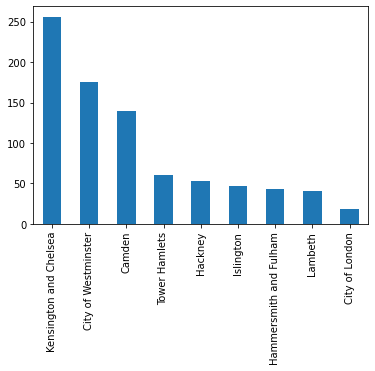

In [226]:
spotahome_eda['neighbourhood'].value_counts().plot(kind='bar');

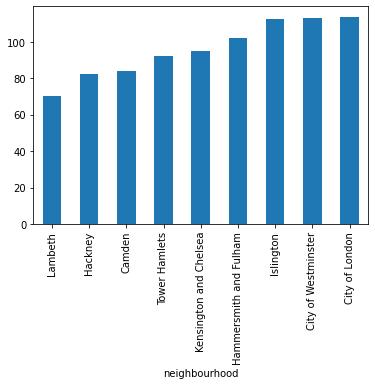

In [227]:
spotahome_eda.groupby('neighbourhood')['price_per_sqm'].mean().sort_values().plot(kind='bar');

## Merge all three platform tables together !Do not run without checking the other tables!

In [228]:
# sql_text = f"""
# CREATE TABLE platforms_complete AS
# (SELECT *
#  FROM spotahome_clean
#  UNION
#  SELECT *
#  FROM blueground_clean
#  UNION
#  SELECT *
#  FROM rightmove_clean);
#  """
# result = engine.execute(sql_text)